# ENGG\*3130 Project: CartPole Game
By: Brandon, Dylan, and Gwyneth

## Requirements
To install the requirements please run `pip install -r requirements.txt` inside of this directory. It will install the following dependencies:
- `gym`
- `matplotlib`
- `control`
- `keras`
- `tensorflow`

In [1]:
! pip install -r requirements.txt

    100% |████████████████████████████████| 583kB 915kB/s eta 0:00:01
  Found existing installation: setuptools 36.6.0
    Uninstalling setuptools-36.6.0:
      Successfully uninstalled setuptools-36.6.0
You are using pip version 9.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Introduction
Cartpole is a game provided by OpenAI Gym that is commonly used for evaluating various machine learning algorithms. Gym is a toolkit for developing and comparing reinforcement learning algorithms. Gym provides is a library of environments that can be used to test various algorithms in order to complete the objectives of the games. These games range from simple controls to classic arcade games which involve more complicated controls.

Cartpole consists of a pole that is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force towards the right or left of the cart. The game starts with the pendulum upright and the goal is to prevent it from falling over. Scoring is determined by awarding a point for each timestep the pole remains upright. The game is finished when the pole is more than 15 degrees from vertical or if the cart moves more than 2.4 units from the center.

## Testing
Before starting to create our strategies we must first determine how we are to test the game out. We have decided to let the game run for a set amount of episodes and then analyze the highest score acheived as well as the average score. We will then plot the scores as well as the strategies graph for it's highest score.

First we will import `BaseStrategy` and `Game` from the `Game.py` file. `BaseStrategy` is a class that get's information about the pole as well as lets the pole make actions. For Cartpole, these actions involve whether the base of the pendulum will be pushed left or right at each frame. `Game` contains code in order to run the game with a given strategy, log all of it's results, and plot those results. 

In [2]:
from Game import Game, BaseStrategy

We will then determine how many episodes we will like to run and whether or not to render the game. For the purpose of this notebook we will not be rendering the game as it takes too long to complete each episode.

In [3]:
episodes = 200
render = False

Next we will create a function `play_game` in order to play the Strategies we will be testing.

In [4]:
def play_game(strategy, title="", episodes=100):
    game = Game(episodes, strategy(), render)
    game.play()
    game.close()
    game.plot(title)

### Random Strategy
The Random Strategy will be the first strategy we will try to implement. It will randomly select a float from 0 to 1 using the `random` library and determine if the the CartPole will move left or right. 

In [5]:
import random

class RandomStrategy(BaseStrategy):
    def calculate(self, observation):
        if random.random() < 0.5:
            return self.make_move_left_action()
        else:
            return self.make_move_right_action()

High Score: 101, Average Score: 21.55


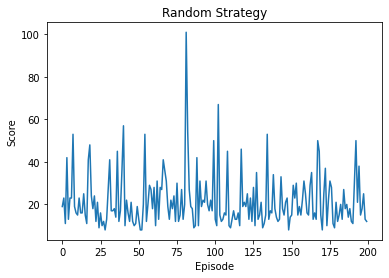

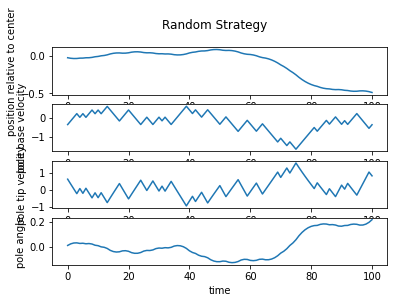

In [6]:
play_game(RandomStrategy, "Random Strategy", episodes)

### Brute Force Strategies
For Brute Force strategies we decided on 4 different ones. Position, Angle, Tip Velocity, and Tip Velocity and Position Strategy. These all track their respective component and moves the pole accordingly. 

#### Position Strategy
If the position of the pole is left of the center, push the pole right or vice versa

In [7]:
class PositionStrategy(BaseStrategy):
    def calculate(self, observation):        
        if (self.is_pole_positioned_right(observation)):
            return self.make_move_left_action()
        else:
            return self.make_move_right_action()

High Score: 54, Average Score: 28.64


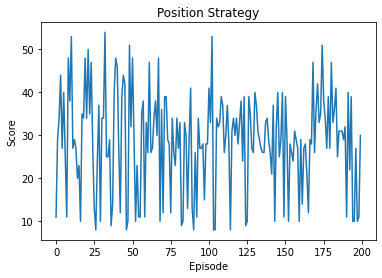

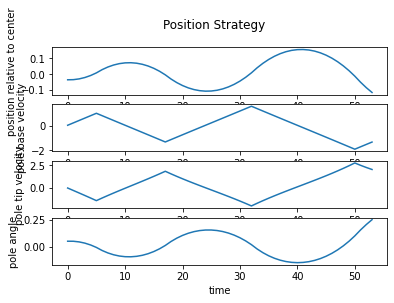

In [8]:
play_game(PositionStrategy, "Position Strategy", episodes)

#### Angle Strategy
If the angle of the pole is left, push the pole left to fix the angle and vice versa

In [9]:
class AngleStrategy(BaseStrategy):
    def calculate(self, observation):        
        if (self.is_pole_angled_left(observation)):
            return self.make_move_left_action()
        else:
            return self.make_move_right_action()

High Score: 65, Average Score: 42.04


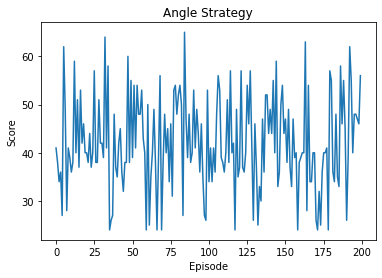

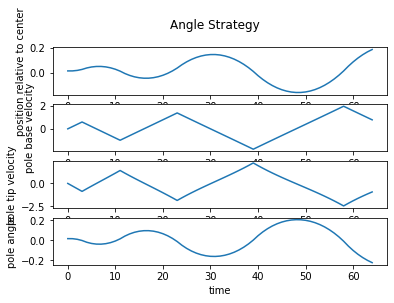

In [10]:
play_game(AngleStrategy, "Angle Strategy", episodes)

#### Tip Velocity Strategy
If the tip of the pole is going left, push the pole left or vice versa

In [11]:
class TipVelocityStrategy(BaseStrategy):
    def calculate(self, observation):        
        if (self.is_pole_tip_velocity_left(observation)):
            return self.make_move_left_action()
        else:
            return self.make_move_right_action()

High Score: 300, Average Score: 197.88


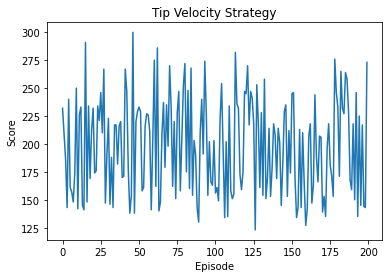

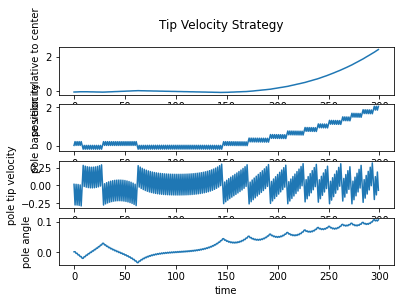

In [12]:
play_game(TipVelocityStrategy, "Tip Velocity Strategy", episodes)

#### Tip Velocity and Position Strategy
If the tip of the pole is going left, push the pole left or vice versa. If the position of the pole is not centered, push the pole back to the center.

In [13]:
class TipVelocityAndPositionStrategy(BaseStrategy):
    count = 0

    def calculate(self, observation):
        self.count = self.count + 1

        if self.count % 2 == 0:
            if (self.is_pole_positioned_right(observation)):
                return self.make_move_left_action()
            else:
                return self.make_move_right_action()

        if (self.is_pole_tip_velocity_left(observation)):
            return self.make_move_left_action()
        else:
            return self.make_move_right_action()

High Score: 229, Average Score: 63.3


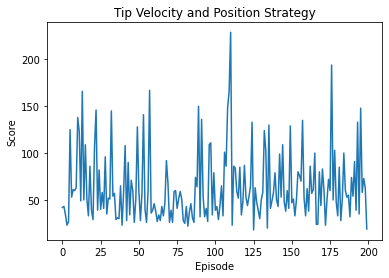

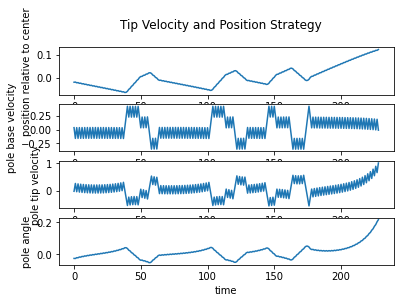

In [14]:
play_game(TipVelocityAndPositionStrategy, "Tip Velocity and Position Strategy", episodes)

### PID Controller Strategy
This strategy utilizes a PID controller in order to try and keep the pole balanced and not fall outside of the given parameters. 

In [15]:
import control
import math

"""
m: mass of pendulum 
M: mass of cart
b: coefficient of friction of the cart (zero in this case)
I: inertia of the pendulum (might be 0?)
l = length of the pendulum 
q = (M+m) * (I+m*(l^2))-((m*l)^2)
closed loop transfer_function = Theta(s)/Force(s) = (-m*l*s)/q)  / ( (s^3) + ((b*(m(l^2) + I)/q)*(s^2) + (((M + m)*g*m*l)/q)*s +  b*m*g*l/q

No significance to values for this model
kd = 1
kp = 1
ki = 1
pid_controller = kd*s + kp + (ki/s)
open_loop_transfer_function = ((-self.m*self.l)/q) / ((s^2) + (((self.M + self.m)*self.g*self.m*self.l)/q))

"""
class PIDStrategy(BaseStrategy):

        def __init__(self):
                self.g = 9.8
                self.m = 0.1
                self.M = 1.0
                self.l = 1.0 # or 0.5?
                self.I = 0

        def pid_controller_pendulum (self, observation):

                error = (180/math.pi) * self.get_pole_angle(observation)
                #amount of deviation from vertical 

                q = (self.M+self.m) * (self.I+self.m*(self.l**2))-((self.m*self.l)**2)
                #q => setting reocurring constants
                open_loop_transfer_function = control.TransferFunction([((-self.m*self.l)/q)], [1, 0, (((self.M + self.m)*self.g*self.m*self.l)/q)])
                
                kd = 1000 
                kp = -100
                ki = 0

                pid_controller = control.TransferFunction([kd, kp, ki], [1, 0])
                #setting up control function
                transfer_function = (open_loop_transfer_function/(1 + open_loop_transfer_function*pid_controller)) 
                #closed loop = open/(1 + (open*control func))                               
                t, force_array = control.impulse_response(transfer_function, X0 = error)
                #gives an impulse and stores how it responds over time
                #IC = starting angle (error), creates a time array (t) and force array, the latter is the actual system output
                force =  force_array[0]
                #only care about first value as it corresponds to our IC

                return force

        def calculate (self, observation):

                force = self.pid_controller_pendulum(observation)

                if (force >= 0):
                        action = self.make_move_left_action()
                        # sol = self.make_more_....()*force
                elif (force < 0):
                        action = self.make_move_right_action()

                return action 

High Score: 63, Average Score: 41.195


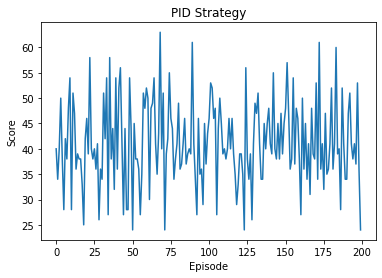

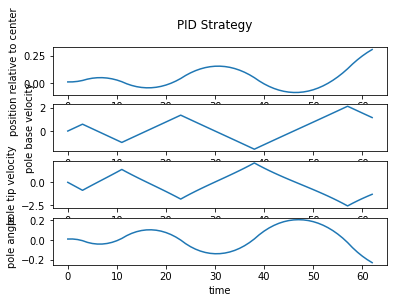

In [16]:
play_game(PIDStrategy, "PID Strategy", episodes)

### Genetic Algorithm
A genetic algorithm is a reinforcement learning algorithm that mimics the process of natural selection. 

The steps of the algorithm are as follows:
1. Create a population of randomized agents.
2. Have each agent play the game to completion.
3. Calculate the fitness value for each agent after they play the game. In the case of cartpole their fitness is calculated based on their score normalized to the rest of the populations of agents.
4. Create a mating pool from the agents with a population distribution based off of their fitness values. The agents with a higher fitness value will represent a higher percentage of the mating pool.
5. Perform natural selection amongst the mating pool to create the next generation of agents. This involves selecting two random parents from the mating pool and crossing their actions taken while playing the cartpole game.
6. Selectively mutate the action sequences of agents within the next generation in order to introduce mutations of strategies into the mating pool.
7. Repeat steps 2 - 7 for a number of episodes until the training process completes.

In our implementation, the actions that are taken (push the cart left or right) are stored as a list for each agent. This sequence of actions acts as the DNA of the agent and is how the agent interacts within the environment. This sequence of actions are the component of the agent that undergoes natural selection. The fitness of each agent is mapped directly to their score that they achieved after playing the game once.

In [17]:
from Game import Game, BaseStrategy
import gym
import numpy as np
import math
import random

class Agent(BaseStrategy):
    def __init__(self, default_action_length, actions=None):
        
        # index kept to track current action
        self.idx = 0

        if actions:
            # initialize agent with predefined actions
            self.actions = actions
        else:
            # initialize with random actions
            self.actions = []
            for _ in range(default_action_length):
                self.actions.append(self.create_random_action())

    def reset(self):
        # Go back to the start of the actions sequence
        self.idx = 0

    def calculate(self, observation):
        if self.idx == len(self.actions):
            # run out of actions
            return self.emit_end_game_signal()
        else:
            # get current action
            current_action = self.actions[self.idx]
            self.idx += 1
            return current_action

    def calculate_fitness(self, env):
        total = 0

        # play the game ot completion and keep track of score
        for action in self.actions:
            observation, reward, done, info = env.step(action)
            if done:
                break
            else:
                total += 1

        return total

In [18]:
class Population:
    def __init__(self, pop_size, mutation_rate=0.01, default_action_length=1000):
        # initialize population
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.agents = []
        self.env = gym.make('CartPole-v1')
        self.default_action_length = default_action_length

        # create set of random agents
        for _ in range(pop_size):
            self.agents.append(Agent(default_action_length=self.default_action_length))

    def next_generation(self):
        # create a mating pool
        mating_pool, max_agent, max_fitness = self.create_mating_pool()
        
        # do natural selection on the mating pool
        new_agents = self.natural_selection(mating_pool)

        # randomly mutate some of the agents
        for agent in new_agents:
            self.mutate(agent)

        # next generation of agents
        self.agents = new_agents

        # return the best agent from the evolution
        return max_agent, max_fitness

    def calculate_max_fitness(self):
        # find the agent that has the highest fitness value
        max_fitness = -1
        max_agent = None
        for agent in self.agents:
            self.env.reset()
            fitness = agent.calculate_fitness(self.env)
            if fitness > max_fitness:
                max_fitness = fitness
                max_agent = agent
        return max_fitness, max_agent

    def create_mating_pool(self):
        mating_pool = []

        max_fitness, max_agent = self.calculate_max_fitness()
        for agent in self.agents:
            # find the distribution of the agent in the mating pool
            n = math.floor(self.calculate_normalized_fitness(agent, max_fitness) * self.pop_size)
            for _ in range(n):
                mating_pool.append(agent)
        return mating_pool, max_agent, max_fitness

    def natural_selection(self, mating_pool):
        new_agents = []
        for _ in range(self.pop_size):
            # select two random parents (naturally following mating pool distribution)
            parentA = random.choice(mating_pool)
            parentB = random.choice(mating_pool)
            
            # DNA crossover between the two parents
            child = self.crossover(parentA, parentB)
            
            # append to next evolution of agents
            new_agents.append(child)
        return new_agents

    def crossover(self, parentA, parentB):
        new_actions = []

        # pick a midpoint for the actions of the parent
        l = len(parentA.actions)
        midpoint = math.floor(np.random.random() * l)

        # copy first part of actions from parentA and second part from parentB
        for i in range(l):
            if i < midpoint:
                new_actions.append(parentA.actions[i])
            else:
                new_actions.append(parentB.actions[i])

        # return a new agent with a new list of actions
        return Agent(actions=new_actions, default_action_length=self.default_action_length)

    def mutate(self, agent):
        # mutate the agent by introducing a random action
        for i in range(len(agent.actions)):
            if np.random.random() < self.mutation_rate:
                agent.actions[i] = agent.create_random_action()

    def calculate_normalized_fitness(self, agent, max_fitness):
        self.env.reset()
        return agent.calculate_fitness(self.env) / max_fitness

Now we can train the agents via the genetic algorithm.

In [19]:
def train_genetic_algorithm(pop_size=100, mutation_rate=0.001, default_action_length=1000, training_episodes=500):
    pop = Population(pop_size, mutation_rate, default_action_length)
    m_max_agent = None
    m_max_fitness = 0

    for episode in range(training_episodes):
        max_agent, max_fitness = pop.next_generation()
        if max_fitness > m_max_fitness:
            m_max_fitness = max_fitness
            m_max_agent = max_agent
        print("max fitness: " + str(m_max_fitness) + " " + str(episode) + "/" + str(training_episodes))

    return m_max_agent, m_max_fitness

In [20]:
max_agent, max_fitness = train_genetic_algorithm(pop_size=250, mutation_rate=0.01, default_action_length=1000, training_episodes=300)

max fitness: 96 0/300
max fitness: 97 1/300
max fitness: 97 2/300
max fitness: 97 3/300
max fitness: 97 4/300
max fitness: 101 5/300
max fitness: 101 6/300
max fitness: 101 7/300
max fitness: 102 8/300
max fitness: 102 9/300
max fitness: 102 10/300
max fitness: 109 11/300
max fitness: 109 12/300
max fitness: 109 13/300
max fitness: 109 14/300
max fitness: 109 15/300
max fitness: 109 16/300
max fitness: 109 17/300
max fitness: 118 18/300
max fitness: 118 19/300
max fitness: 118 20/300
max fitness: 118 21/300
max fitness: 118 22/300
max fitness: 118 23/300
max fitness: 118 24/300
max fitness: 118 25/300
max fitness: 118 26/300
max fitness: 118 27/300
max fitness: 118 28/300
max fitness: 118 29/300
max fitness: 118 30/300
max fitness: 121 31/300
max fitness: 121 32/300
max fitness: 121 33/300
max fitness: 121 34/300
max fitness: 121 35/300
max fitness: 121 36/300
max fitness: 121 37/300
max fitness: 121 38/300
max fitness: 121 39/300
max fitness: 121 40/300
max fitness: 121 41/300
max fit

In [21]:
def play_game_genetic_algorithm(strategy, title="", episodes=50, render=False, plot=True):
    game = Game(episodes, strategy, render)
    game.play()
    if plot:
        game.plot(title)
    game.close()

High Score: 72, Average Score: 22.08


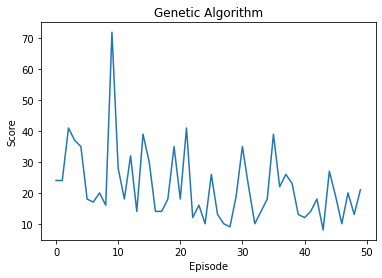

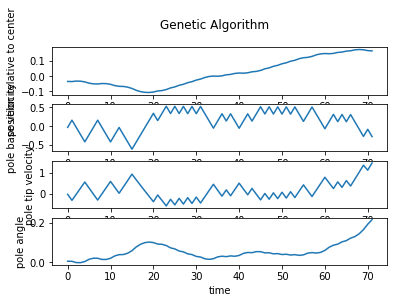

In [22]:
play_game_genetic_algorithm(max_agent, "Genetic Algorithm")

### DQN Strategy
DQN is a reinforcement learning technique that can be used to solve CartPole. We will split up the strategy in a few parts. First part is to setup a Network class in order to compute the reinforcement learning. Next we will actually solve the game then plot it. Lastly is to have a different way of playing the game due to the reinforcement learning part.

In [23]:
from Logger import Logger, ScoreLogger
import gym
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import rmsprop, Adam
import numpy as np
from collections import deque
from statistics import mean
import h5py

LEARNING_RATE = 1e-3
MAX_MEMORY = 1000000
BATCH_SIZE = 20
GAMMA = 0.95
EXPLORATION_DECAY = 0.995
EXPLORATION_MIN = 0.01

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
class Network:
    def __init__(self, observation_space, action_space):
        self.action_space = action_space
        self.memory = deque(maxlen=MAX_MEMORY)
        self.exploration_rate = 1.0

        self.model = Sequential()
        self.model.add(Dense(32, input_shape=(observation_space,), activation='relu'))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(self.action_space, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(lr=LEARNING_RATE))

    def add_to_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def take_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(0, self.action_space)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        else:
            minibatch = random.sample(self.memory, BATCH_SIZE)
            for state, action, reward, state_next, done in minibatch:
                Q = reward
                if not done:
                    Q = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
                Q_values = self.model.predict(state)
                Q_values[0][action] = Q
                self.model.fit(state, Q_values, verbose=0)
            self.exploration_rate *= EXPLORATION_DECAY
            self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def get_model(self):
        return self.model

In [25]:
class DQNGameSolver(BaseStrategy):
    def __init__(self, max_episodes, render=False):
        self.max_episodes = max_episodes
        self.logger = Logger()
        self.scorelogger = ScoreLogger()
        self.render = render
        self.highscore = -1
        self.totalscore = 0

        self.score_table = deque(maxlen=400)
        self.average_of_last_runs = None
        self.model = None
        env = gym.make('CartPole-v1')
        observation_space = env.observation_space.shape[0]
        action_space = env.action_space.n
        self.solver = Network(observation_space, action_space)

    def log_score(self, score):
        self.totalscore += score
        self.scorelogger.log(score)

    def log_observation(self, observation, logger):
        logger.log(
             self.get_pole_position(observation),
             self.get_pole_velocity(observation),
             self.get_pole_angle(observation),
             self.get_pole_tip_velocity(observation)
         )

    def plot(self, title=""):
        print("High Score: " + str(self.highscore) + ", Average Score: " + str(self.totalscore/self.max_episodes))
        self.scorelogger.plot(title)
        self.logger.plot(title)
        
    def print_logs(self):
         print(self.logger.get_positions())
         print(self.logger.get_velocities())
         print(self.logger.get_angles())
         print(self.logger.get_tip_velocities())
         print(self.scorelogger.get_scores())

    def play(self):
        env = gym.make('CartPole-v1')
        observation_space = env.observation_space.shape[0]
        action_space = env.action_space.n

        self.model = self.solver.get_model()
        episode = 0
        while episode < self.max_episodes:

            episode += 1
            state = env.reset()
            state = np.reshape(state, [1, observation_space])
            step = 0
            logger = Logger()

            while True:

                step += 1
                if self.render:
                    env.render()
                
                action = self.solver.take_action(state)
                state_next, reward, done, info = env.step(action)

                self.log_observation(state_next, logger)

                if not done:
                    reward = reward
                else:
                    reward = -reward
                state_next = np.reshape(state_next, [1, observation_space])
                self.solver.add_to_memory(state, action, reward, state_next, done)
                state = state_next

                if done:
                    self.log_score(step)
                    if step > self.highscore:
                        self.highscore = step
                        self.logger = logger

                    env.close()
                    break
                self.solver.experience_replay()

In [26]:
def play_dqn_game(title="", episodes=100):
    game = DQNGameSolver(episodes, render)
    game.play()
    game.plot(title)


High Score: 500, Average Score: 184.05


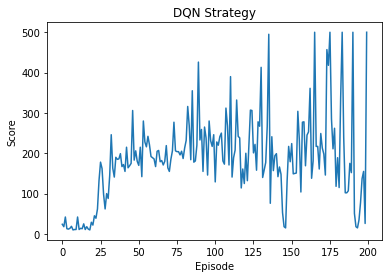

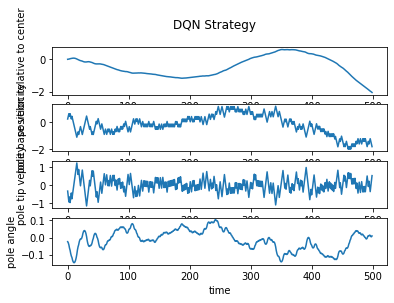

In [27]:
play_dqn_game("DQN Strategy", episodes)

## Conclusions
As we can see there are a lot of ways to solve the CartPole game with varying results from each type of strategy.

## References
DQN Strategy: https://medium.com/@siddharthkale/solving-cartpole-v1-4be909b7c2c6